In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, Add, Flatten, Layer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2024-06-13 07:08:34.313357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 07:08:34.313496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 07:08:34.447642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_images_from_directory(directory, label):
    data = []
    labels = []
    filenames = []

    for filename in tqdm(os.listdir(directory), desc=f"Loading {directory}"):
        filepath = os.path.join(directory, filename)
        with Image.open(filepath) as img:
            img = img.convert('L')  # Convert to grayscale
            img = img.resize((256, 256))  # Resize to 256x256 pixels
            img_array = np.array(img)
            data.append(img_array)
            labels.append(label)
            filenames.append(filename)

    return np.array(data), np.array(labels), filenames

In [3]:
# Directories
yes_processed_directory = '/kaggle/input/adjusted/BrainTumorDataset-Preprocessed/yes'
no_processed_directory = '/kaggle/input/adjusted/BrainTumorDataset-Preprocessed/no'

In [4]:
# Load data
yes_processed_data, yes_processed_labels, yes_processed_filenames = load_images_from_directory(yes_processed_directory, 1)  # 1 for tumor
no_processed_data, no_processed_labels, no_processed_filenames = load_images_from_directory(no_processed_directory, 0)  # 0 for no tumor

Loading /kaggle/input/adjusted/BrainTumorDataset-Preprocessed/yes: 100%|██████████| 155/155 [00:00<00:00, 176.05it/s]
Loading /kaggle/input/adjusted/BrainTumorDataset-Preprocessed/no: 100%|██████████| 155/155 [00:00<00:00, 182.34it/s]


In [6]:
# Function to crop images based on contours
def contour_cropping(images, add_pixels_value=0, target_size=(256, 256)):
    cropped_images = []
    for img in images:
        # Ensure img is a numpy array with dtype 'uint8'
        img = img.astype(np.uint8)
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            x_start = max(0, x - add_pixels_value)
            y_start = max(0, y - add_pixels_value)
            x_end = min(img.shape[1], x + w + add_pixels_value)
            y_end = min(img.shape[0], y + h + add_pixels_value)
            cropped_image = img[y_start:y_end, x_start:x_end]
        else:
            # If no contours are found, use the original image
            cropped_image = img

        # Resize cropped image to the target size
        resized_image = cv2.resize(cropped_image, target_size)
        cropped_images.append(resized_image)

    return np.array(cropped_images)

In [7]:
# Optionally apply contour cropping
yes_processed_cropped_data = contour_cropping(yes_processed_data)
no_processed__cropped_data = contour_cropping(no_processed_data)

In [8]:
def display_sample_images(data, labels, num_samples=5, title_prefix=''):
    
    plt.figure(figsize=(15, 3))  # Set the figure size for better visibility
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)  # 1 row, num_samples columns, ith subplot
        plt.imshow(data[i], cmap='gray')  # Display an image in grayscale
        plt.title(f'{title_prefix} - Label: {labels[i]}')
        plt.axis('off')  # Turn off axis numbering and ticks
    plt.show()

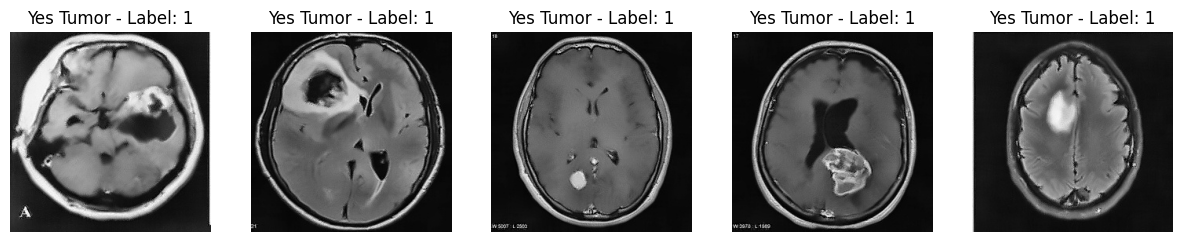

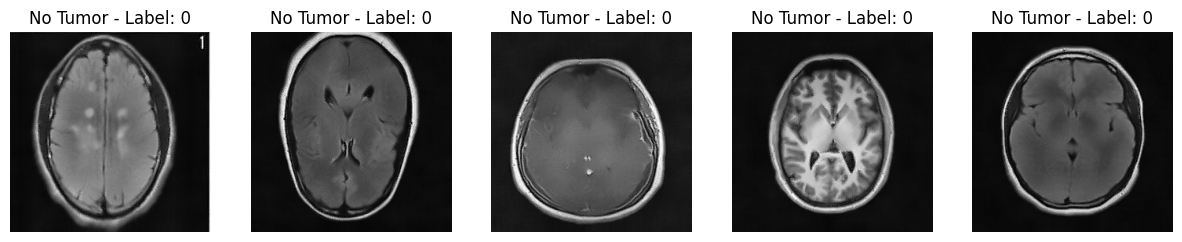

In [9]:
# Display 5 images from the 'yes' preprocessed dataset
display_sample_images(yes_processed_data, yes_processed_labels, num_samples=5, title_prefix='Yes Tumor')

# Display 5 images from the 'no' cropped dataset
display_sample_images(no_processed_data, no_processed_labels, num_samples=5, title_prefix='No Tumor')

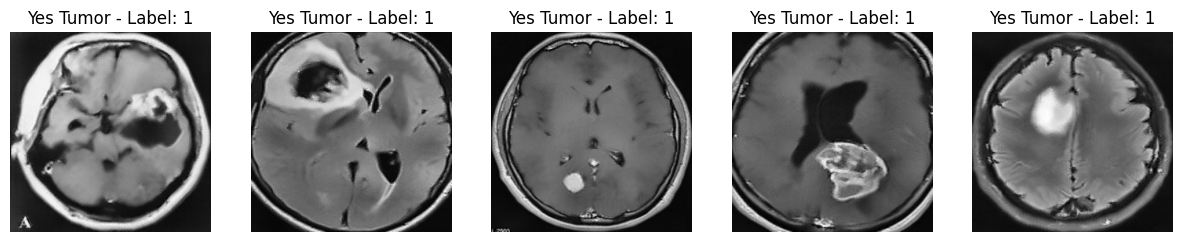

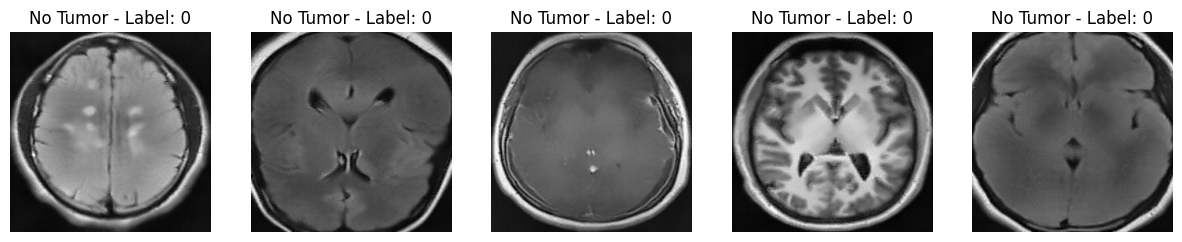

In [10]:
# Display 5 images from the 'yes' cropped dataset
display_sample_images(yes_processed_cropped_data, yes_processed_labels, num_samples=5, title_prefix='Yes Tumor')

# Display 5 images from the 'no' cropped dataset
display_sample_images(no_processed__cropped_data, no_processed_labels, num_samples=5, title_prefix='No Tumor')

In [11]:
# Combine the datasets
X = np.concatenate((yes_processed_data, no_processed_data))
y = np.concatenate((yes_processed_labels, no_processed_labels))

In [12]:
# First split: Separate 70% for training and 30% for temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: Divide the temp data equally into validation and test sets (50% each of 30% => 15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [13]:
# Add a channel dimension to indicate grayscale
X_train = np.expand_dims(X_train, axis=-1)  # Add a new axis at the end
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Print the shapes of the datasets to verify the new dimensions
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (217, 256, 256, 1) (217,)
Validation set shape: (46, 256, 256, 1) (46,)
Test set shape: (47, 256, 256, 1) (47,)


In [14]:
# Create image data generators for training and testing
# Normalizing and augmenting only the training data
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=15,# Random rotations
    width_shift_range=0.05,# Random horizontal shifts
    height_shift_range=0.05,# Random vertical shifts
    shear_range=0.05,# Shear transformations
    zoom_range=0.05,# Random zoom
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,# Horizontal flipping
     vertical_flip=True,# Vertical flipping
    fill_mode='nearest' # Strategy for filling in newly created pixels
)

# Only rescale validation and test data
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare iterators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32,shuffle=True)
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=32,shuffle=False)
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=32,shuffle=False)


In [15]:
class GrayToRGB(Layer):
    def __init__(self):
        super(GrayToRGB, self).__init__()
    
    def call(self, inputs):
        # Ensure the input is 4D
        if inputs.shape[-1] != 1:
            raise ValueError('Expected input to GrayToRGB to have 1 channel')
        return tf.image.grayscale_to_rgb(inputs)

def create_model(input_shape):
    input_layer = Input(shape=input_shape)
    rgb_layer = GrayToRGB()(input_layer)

    # Output shape check after GrayToRGB
    print("Shape after GrayToRGB:", rgb_layer.shape)

    base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=rgb_layer)

    # Enable training for the base model's layers
    for layer in base_model.layers:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Example use
model_proposed_model = create_model((256, 256, 1))
model_proposed_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
model_proposed_model.summary()

Shape after GrayToRGB: (None, 256, 256, 3)
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_to_rgb         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (GrayToRGB)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ gray_to_rgb[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]  

 Total params: 22,920,225 (87.43 MB)

 Trainable params: 22,884,513 (87.30 MB)

 Non-trainable params: 35,712 (139.50 KB)

In [16]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)


early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

history_proposed_model = model_proposed_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718262858.655404     187 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - Precision: 0.4275 - Recall: 0.4359 - accuracy: 0.4375 - loss: 11.6271 
Epoch 1: val_accuracy improved from -inf to 0.69565, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 178s 13s/step - Precision: 0.4327 - Recall: 0.4422 - accuracy: 0.4410 - loss: 11.6061 - val_Precision: 0.7368 - val_Recall: 0.6087 - val_accuracy: 0.6957 - val_loss: 10.8591
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - Precision: 0.5611 - Recall: 0.5724 - accuracy: 0.5965 - loss: 11.2746
Epoch 2: val_accuracy improved from 0.69565 to 0.76087, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - Precision: 0.5626 - Recall: 0.5685 - accuracy: 0.5928 - loss: 11.2727 - val_Precision: 0.7500 - val_Recall: 0.7826 - val_accuracy: 0.7609 - val_loss: 10.7820
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - Precision: 0.6701 - Recall: 0.7171 - accuracy: 0.6764 - loss: 11.0455
Epoch 3: val_accuracy improved from 0.76087 to 0.78261, saving model to b

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Precision: 0.9697 - Recall: 0.9420 - accuracy: 0.9574 - loss: 8.6504
Test Loss: 8.69676685333252
Test Accuracy: 0.936170220375061
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step


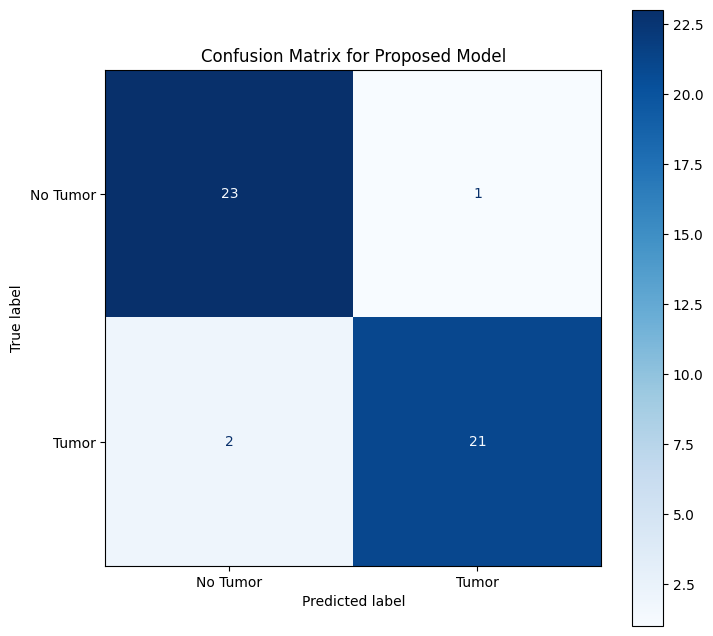

Classification Report for Proposed Model:
               precision    recall  f1-score   support

    No Tumor       0.92      0.96      0.94        24
       Tumor       0.95      0.91      0.93        23

    accuracy                           0.94        47
   macro avg       0.94      0.94      0.94        47
weighted avg       0.94      0.94      0.94        47



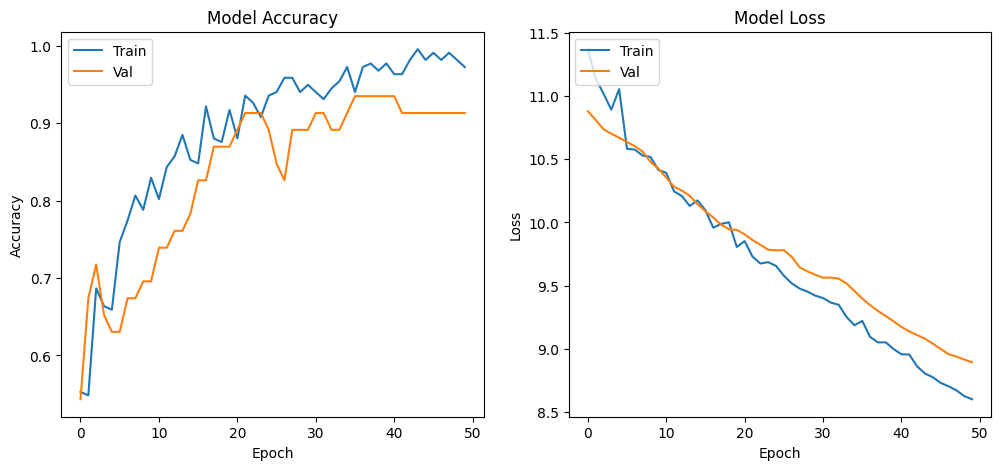

In [16]:
# Evaluate the model on the test data
test_metrics_proposed_model = model_proposed_model.evaluate(test_generator)
print('Test Loss:', test_metrics_proposed_model[0])
print('Test Accuracy:', test_metrics_proposed_model[1])

# Generate predictions
true_classes_proposed_model = y_test
predictions_proposed_model = model_proposed_model.predict(test_generator)
predicted_classes_proposed_model = (predictions_proposed_model > 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix_proposed_model= confusion_matrix(true_classes_proposed_model, predicted_classes_proposed_model)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix_proposed_model, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Proposed Model')
plt.show()

# Generate the classification report
report_proposed_model = classification_report(true_classes_proposed_model, predicted_classes_proposed_model, target_names=['No Tumor', 'Tumor'])
print("Classification Report for Proposed Model:\n", report_proposed_model)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_proposed_model.history['accuracy'])
plt.plot(history_proposed_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_proposed_model.history['loss'])
plt.plot(history_proposed_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


In [17]:
class GrayToRGB(Layer):
    def __init__(self):
        super(GrayToRGB, self).__init__()

    def call(self, inputs):
        return tf.image.grayscale_to_rgb(inputs)

# Define the input shape for a grayscale image
input_shape = (256, 256, 1)  # Only one channel for grayscale

# Create the input layer that takes grayscale images
input_layer = Input(shape=input_shape)

# Use the custom GrayToRGB layer to convert grayscale to RGB
rgb_layer = GrayToRGB()(input_layer)# Freeze the layers of the base model
# Load Inception V3, excluding the top fully connected layer, using the RGB layer as input
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=rgb_layer)
# Freeze the layers of the base model
for layer in inception_base.layers:
    layer.trainable = False

# Simplify the model by not adding additional complex layers
x = GlobalAveragePooling2D()(inception_base.output)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification: yes (tumor) or no (no tumor)

# Finalize the model
model_proposed_model2 = Model(inputs=input_layer, outputs=output_layer)
model_proposed_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the architecture
model_proposed_model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_to_rgb_1       │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GrayToRGB)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 127, 127,  │        864 │ gray_to_rgb_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 125, 125,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 125, 125,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 62, 62,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 62, 62,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 60, 60,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_98[0][0] 

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
history_model_proposed_model2 = model_proposed_model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5963 - loss: 0.6577 - val_accuracy: 0.6304 - val_loss: 0.6415
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6275 - loss: 0.6408 - val_accuracy: 0.6957 - val_loss: 0.5852
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7558 - loss: 0.5425 - val_accuracy: 0.7609 - val_loss: 0.5196
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7761 - loss: 0.5394 - val_accuracy: 0.7609 - val_loss: 0.4995
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8078 - loss: 0.4680 - val_accuracy: 0.8043 - val_loss: 0.4614
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8027 - loss: 0.4461 - val_accuracy: 0.8043 - val_loss: 0.4423
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7993 - loss: 0.4637 - val_accuracy: 0.8261 - val_loss: 0.4230
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7927 - loss: 0.4550 - val_accuracy: 0.8478 - val_loss: 0.4095
E

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.9366 - loss: 0.2475 
Test Loss: 0.2448432594537735
Test Accuracy: 0.936170220375061
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step


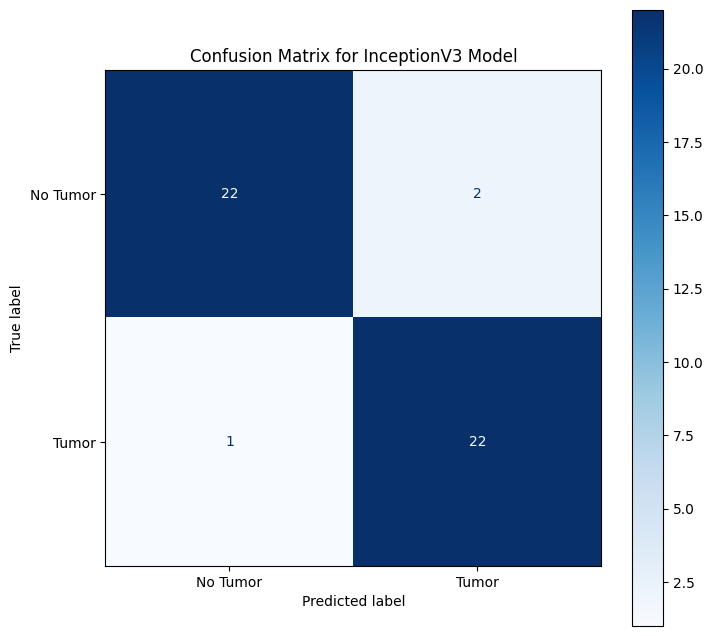

Classification Report for InceptionV3 Model:
               precision    recall  f1-score   support

    No Tumor       0.96      0.92      0.94        24
       Tumor       0.92      0.96      0.94        23

    accuracy                           0.94        47
   macro avg       0.94      0.94      0.94        47
weighted avg       0.94      0.94      0.94        47



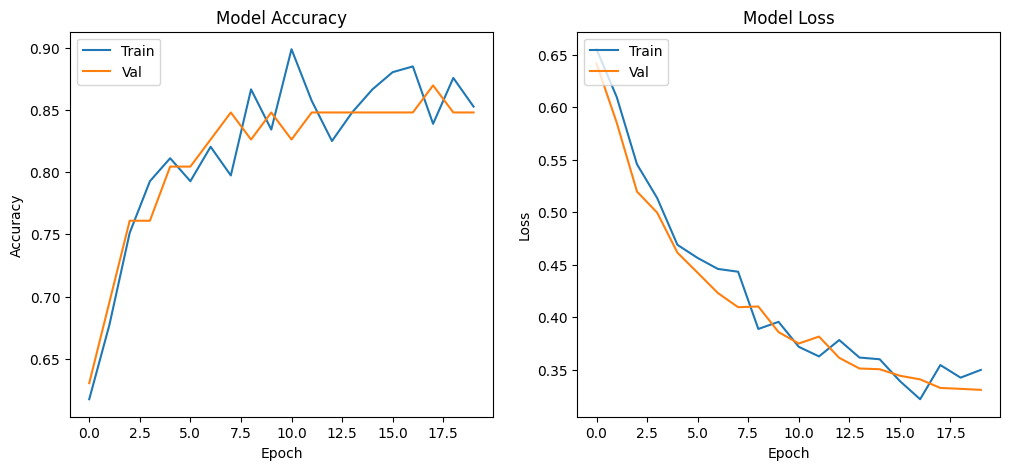

In [19]:
# Evaluate the model on the test data
test_metrics_model_proposed_model23 = model_proposed_model2.evaluate(test_generator)
print('Test Loss:', test_metrics_model_proposed_model23[0])
print('Test Accuracy:', test_metrics_model_proposed_model23[1])

# Generate predictions
true_classes_model_proposed_model2 = y_test
predictions_model_proposed_model2= model_proposed_model2.predict(test_generator)
predicted_classes_model_proposed_model2 = (predictions_model_proposed_model23> 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix_model_proposed_model2 = confusion_matrix(true_classes_model_proposed_model2, predicted_classes_model_proposed_model2)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix_model_proposed_model2, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for InceptionV3 Model')
plt.show()

# Generate the classification report
report_model_proposed_model2 = classification_report(true_classes_model_proposed_model2, predicted_classes_model_proposed_model2, target_names=['No Tumor', 'Tumor'])
print("Classification Report for InceptionV3 Model:\n", report_model_proposed_model2)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_model_proposed_model2.history['accuracy'])
plt.plot(history_model_proposed_model2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_model_proposed_model2.history['loss'])
plt.plot(history_model_proposed_model2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()
